In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from torchvision.datasets import STL10
stl10_unlabeled = STL10("./data", split="unlabeled", download=True)

/Users/andru/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


Files already downloaded and verified


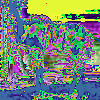

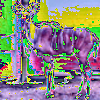

100000


In [24]:
from dataset import AugmentedDataset
import torchvision.transforms.functional as tvf
ds = AugmentedDataset(stl10_unlabeled, (100,100))
display(tvf.to_pil_image(ds.get_image(0, True)[0][0]))
display(tvf.to_pil_image(ds.get_image(0, True)[0][1]))
print(len(ds))

In [5]:
import torchvision, torch
base_model = torchvision.models.efficientnet_b0(from_pretrained=True)

class Identity(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x
    
base_model.classifier = Identity()
base_out_size = base_model(ds[0][0][0].unsqueeze(0)).shape[1]
print(base_out_size)

1280


In [43]:
from train import SimCLREmbeddor

plmodule = SimCLREmbeddor(ds, base_model, base_out_size, embed_size = 3, temperature = .2, 
                      batch_size = 10, train_count = 100, val_count = 10, lr = .001)

In [29]:
import pytorch_lightning as pl
plmodule.hparams

"base_output_size": 1280
"batch_size":       100
"embed_size":       3
"lr":               0.001
"temperature":      0.2
"train_count":      10000
"val_count":        10

In [39]:
trainer = pl.Trainer(log_every_n_steps = 1, max_epochs = 10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [40]:
lr_find_cls = trainer.tuner.lr_find(plmodule)

Epoch 5:   0%|                                                                                                              | 0/10 [47:00<?, ?it/s, loss=2.86, v_num=1, train_loss_step=2.760, train_loss_epoch=2.840]

/Users/andru/miniforge3/envs/unsup/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
/Users/andru/miniforge3/envs/unsup/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Finding best initial lr: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:34<00:00,  6.94s/it]


8.317637711026709e-07

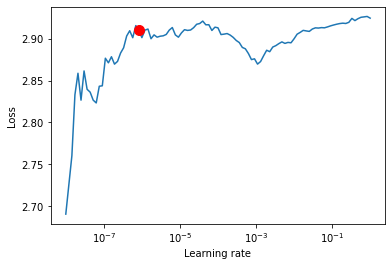

In [41]:
lr_find_cls.plot(show=False, suggest=True)
lr_find_cls.suggestion()

In [ ]:
trainer.fit(plmodule)

In [27]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs/

Reusing TensorBoard on port 6006 (pid 29331), started 12:06:19 ago. (Use '!kill 29331' to kill it.)

In [ ]:
!ls